# Optimization Methods

Until now, you've always used Gradient Descent to update the parameters and minimize the cost. In this notebook, you will learn more advanced optimization methods that can speed up learning and perhaps even get you to a better final value for the cost function. Having a good optimization algorithm can be the difference between waiting days vs. just a few hours to get a good result. <br> 
In this Notebook we will cover and compare:
* **Batch Gradient Descent**
* **Mini-Batch Gradient Descent**
* **Momentum**
* **Adam optimization**
<br>
Implementing a 3 layer neueal  network with the following dimenssions: 
 [train_X.shape[0], 5, 2, 1]

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import math
import sklearn
import sklearn.datasets
%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
# colors for print()
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

print(color.BLUE + "6/23/2020"+ color.END)

6/23/2020


### Load Dataset:

In [3]:
def load_dataset():
    np.random.seed(3)
    train_X, train_Y = sklearn.datasets.make_moons(n_samples=300, noise=.2) #300 #0.2 
    # Visualize the data
    plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
    train_X = train_X.T
    train_Y = train_Y.reshape((1, train_Y.shape[0]))
    
    return train_X, train_Y

SUMMARY OF DATA SET: 

Size of trainning data:  300
SHAPES: X_train: (2, 300)  y_train (1, 300)


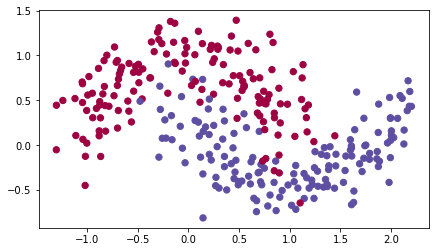

In [4]:
train_X, train_Y = load_dataset()

m_train= train_X.shape[1]
print(color.GREEN + "SUMMARY OF DATA SET: \n" + color.END)
print("Size of trainning data: ",m_train)
print("SHAPES:","X_train:",train_X.shape," y_train",train_Y.shape)

# Every Neural Net is divided into at least:
<br>
<font color='blue'>
1.Intialization<br>
<font color='green'>
2.FeedForward<br>
<font color='purple'>  
3.Cost<br>
<font color='red'>
4.BackPropagation<br>
<font color='brown'>
5.Optimization algorithm (such as Gradient Descent)<br>
<font color='black'>
6.Evaluation<br>

We will code our Neural Network acoording to this order, but first we need to decleare  the **activation functions** we will use:

### Activation Functions:

In [5]:
def Sigmoid(Z):
    s = 1/(1+np.exp(-Z))
    return s

def ReLU(Z):
    return Z * (Z > 0)

# Derivatives of Activation Functions:

def dSigmoid(A):
    return A*(1-A)

def dReLU(Z):
    return 1 * (Z > 0)


### 1.Intialization
<font color='black'>
<br>
For this examples we will Use He Initalization, which is similar to He 

Xavier: $ \frac{1}{\sqrt{ l - 1}} $

He:  $ \sqrt{\frac{2}{l - 1}} $

In [6]:
def initialize_parameters_xavier(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    Xavier = 1/sqrt(l-1)
    """
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims) # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

    return parameters

def initialize_parameters_he(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    Xavier = 1/sqrt(l-1)
    """
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims) # number of layers in the network

    for l in range(1, L):                                                          
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1])  *  np.sqrt(2 / layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

    return parameters

### 2.- Feed Forward

In [7]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation
    """
    forward = {}
    forward["A" + str(0)] = X # set A0 to X this will be very helpful for for loopimplementation
    
    Num_of_parameters = len(parameters) // 2  # since we have W and b's  (but W and b share the same indexing for 1 layer)

    for i in range(1,Num_of_parameters+1):
        # LINEAR
        forward["Z"+str(i)] = np.dot(parameters["W"+str(i)], forward["A" + str(i-1)]) + parameters["b"+str(i)]
        
        #ACTIVATION
        if i != Num_of_parameters: # last layer has to have a SIGMOID activation 
            forward["A"+str(i)] = ReLU(forward["Z"+str(i)])
        else:
            forward["A"+str(i)] = Sigmoid(forward["Z"+str(i)])
            
    AL =  forward["A"+str(i)]
    
    return AL, forward

### 3.- Cost 
the implementation of cost for mini batch is a litlte bit different (we no longer divide by m)

In [8]:
def compute_cost(AL, Y):
    """
    Implement the cost function
    """
    
    logprobs = np.multiply(-np.log(AL),Y) + np.multiply(-np.log(1 - AL), 1 - Y)
    cost = np.sum(logprobs)
    
    return cost

### 4.- BackPropagation

In [9]:
def backward_propagation(X, Y,forward,parameters):
    """
    Implement the backward propagation 
    """
    m = X.shape[1]
    gradients = {}
    Num_of_parameters = len(parameters) // 2
    
    AL = list(forward)[-1] #calls last element of dicitonari in this cas AL
    gradients["dZ"+str(Num_of_parameters)] =  forward[AL] - Y #Derivative respect to cost multiply by derivative of sig
    
    for i in range(Num_of_parameters,0,-1):      
        
        if i != Num_of_parameters: # we have already calcualted dZ for AL
            
            gradients["dA"+str(i)]  = np.dot(parameters["W"+str(i+1)].T, gradients["dZ"+str(i+1)])
            gradients["dZ"+str(i)]  = np.multiply(gradients["dA"+str(i)],dReLU(forward["A"+str(i)]))
        
        gradients["dW"+str(i)] = 1./m * np.dot(gradients["dZ"+str(i)],forward["A"+str(i-1)].T)
        gradients["db"+str(i)] = 1./m * np.sum(gradients["dZ"+str(i)], axis=1, keepdims = True)
    
    return gradients

### 5.-Gradient Descent 

In [10]:
def update_parameters(parameters, gradients, learning_rate):
    n = len(parameters) // 2 # number of layers in the neural networks
    # Update rule for each parameter
    for k in range(n):
        parameters["W" + str(k+1)] = parameters["W" + str(k+1)] - learning_rate * gradients["dW" + str(k+1)]
        parameters["b" + str(k+1)] = parameters["b" + str(k+1)] - learning_rate * gradients["db" + str(k+1)]
        
    return parameters

#### 6.- Evaluation

In [11]:
def predict(X, y, parameters):
    m = X.shape[1]
    p = np.zeros((1,m), dtype = np.int)
    
    # Forward propagation
    AL,forward = forward_propagation(X, parameters)
    
    # convert probas to 0/1 predictions
    for i in range(0, AL.shape[1]):
        if AL[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
            
    print("Accuracy: "  + str(np.mean((p[0,:] == y[0,:]))))
    
    return p

def predict_dec(parameters, X):
    """
    Used for plotting decision boundary.
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (m, K)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    # Predict using forward propagation and a classification threshold of 0.5
    AL,forward = forward_propagation(X, parameters)
    predictions = (AL>0.5)
    return predictions

def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
    plt.show()
    

### B) Mini-Batch  Gradient Descent
<br>
Mini-Batch is extremly similar to Batch Gradient Descent. The only difference is that we use samller batches, usually  of sizes 64,128, 256,($2^n$) to train our Neural Network. We learn through those batches instead of waiting for the algorithm to converge. Because of this the error curve may oscilate (since the next batch is unkown data).
<br><br>
It is important to have mini-batches with the same distribution, in order to accomplish that we shuffle the data before creating the mini-batch

In [12]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    np.random.seed(seed)            # To make your "random" minibatches the same as ours
    m = X.shape[1]                  # number of training examples
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1,m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        ### START CODE HERE ### (approx. 2 lines)
        mini_batch_X = shuffled_X[:, (k)*mini_batch_size : (k+1)* mini_batch_size]
        mini_batch_Y = shuffled_Y[:, (k)*mini_batch_size : (k+1)* mini_batch_size]
        ### END CODE HERE ###
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        ### START CODE HERE ### (approx. 2 lines)
        mini_batch_X = shuffled_X[:,num_complete_minibatches * mini_batch_size:]
        mini_batch_Y = shuffled_Y[:,num_complete_minibatches * mini_batch_size:]
        ### END CODE HERE ###
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

# Momentum
Because mini-batch gradient descent makes a parameter update after seeing just a subset of examples, the direction of the update has some variance, and so the path taken by mini-batch gradient descent will "oscillate" toward convergence. Using momentum can reduce these oscillations.

Momentum takes into account the past gradients to smooth out the update. We will store the 'direction' of the previous gradients in the variable  vv . Formally, this will be the exponentially weighted average of the gradient on previous steps. You can also think of  vv  as the "velocity" of a ball rolling downhill, building up speed (and momentum) according to the direction of the gradient/slope of the hill.

<br>
$$ \begin{cases}
v_{dW^{[l]}} = \beta v_{dW^{[l]}} + (1 - \beta) dW^{[l]} \\
W^{[l]} = W^{[l]} - \alpha v_{dW^{[l]}}
\end{cases}\tag{3}$$

$$\begin{cases}
v_{db^{[l]}} = \beta v_{db^{[l]}} + (1 - \beta) db^{[l]} \\
b^{[l]} = b^{[l]} - \alpha v_{db^{[l]}} 
\end{cases}\tag{4}$$

where L is the number of layers, $\beta$ is the momentum and $\alpha$ is the learning rate. All parameters should be stored in the `parameters` dictionary.  Note that the iterator `l` starts at 0 in the `for` loop while the first parameters are $W^{[1]}$ and $b^{[1]}$ (that's a "one" on the superscript). So you will need to shift `l` to `l+1` when coding.



In [13]:
def initialize_velocity(parameters):
    """
    Initializes the velocity as a python dictionary with:
                - keys: "dW1", "db1", ..., "dWL", "dbL" 
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
    """
    
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    
    # Initialize velocity
    for l in range(L):
        v["dW" + str(l+1)] = np.zeros_like(parameters["W" + str(l+1)])
        v["db" + str(l+1)] = np.zeros_like(parameters["b" + str(l+1)])

        
    return v

def update_parameters_with_momentum(parameters, grads, v, beta, learning_rate):
    """
    Update parameters using Momentum
    """

    L = len(parameters) // 2 # number of layers in the neural networks
    
    # Momentum update for each parameter
    for l in range(L):
        # compute velocities
        v["dW" + str(l+1)] = beta*v["dW" + str(l+1)]  + (1-beta)*grads['dW' + str(l+1)]
        v["db" + str(l+1)] = beta*v["db" + str(l+1)]  + (1-beta)*grads['db' + str(l+1)]
        # update parameters
        parameters["W" + str(l+1)] = parameters["W"+ str(l+1)] - learning_rate*v["dW" + str(l+1)] 
        parameters["b" + str(l+1)] = parameters["b"+ str(l+1)] - learning_rate*v["db" + str(l+1)] 
        ### END CODE HERE ###
        
    return parameters, v

**Note** that:
- The velocity is initialized with zeros. So the algorithm will take a few iterations to "build up" velocity and start to take bigger steps.
- If $\beta = 0$, then this just becomes standard gradient descent without momentum. 

**How do you choose $\beta$?**

- The larger the momentum $\beta$ is, the smoother the update because the more we take the past gradients into account. But if $\beta$ is too big, it could also smooth out the updates too much. 
- Common values for $\beta$ range from 0.8 to 0.999. If you don't feel inclined to tune this, $\beta = 0.9$ is often a reasonable default. 
- Tuning the optimal $\beta$ for your model might need trying several values to see what works best in term of reducing the value of the cost function $J$. 

## 4 - Adam

Adam is one of the most effective optimization algorithms for training neural networks. It combines ideas from RMSProp (described in lecture) and Momentum. 

**How does Adam work?**
1. It calculates an exponentially weighted average of past gradients, and stores it in variables $v$ (before bias correction) and $v^{corrected}$ (with bias correction). 
2. It calculates an exponentially weighted average of the squares of the past gradients, and  stores it in variables $s$ (before bias correction) and $s^{corrected}$ (with bias correction). 
3. It updates parameters in a direction based on combining information from "1" and "2".

The update rule is, for $l = 1, ..., L$: 

$$\begin{cases}
v_{dW^{[l]}} = \beta_1 v_{dW^{[l]}} + (1 - \beta_1) \frac{\partial \mathcal{J} }{ \partial W^{[l]} } \\
v^{corrected}_{dW^{[l]}} = \frac{v_{dW^{[l]}}}{1 - (\beta_1)^t} \\
s_{dW^{[l]}} = \beta_2 s_{dW^{[l]}} + (1 - \beta_2) (\frac{\partial \mathcal{J} }{\partial W^{[l]} })^2 \\
s^{corrected}_{dW^{[l]}} = \frac{s_{dW^{[l]}}}{1 - (\beta_2)^t} \\
W^{[l]} = W^{[l]} - \alpha \frac{v^{corrected}_{dW^{[l]}}}{\sqrt{s^{corrected}_{dW^{[l]}}} + \varepsilon}
\end{cases}$$
where:
- t counts the number of steps taken of Adam 
- L is the number of layers
- $\beta_1$ and $\beta_2$ are hyperparameters that control the two exponentially weighted averages. 
- $\alpha$ is the learning rate
- $\varepsilon$ is a very small number to avoid dividing by zero

As usual, we will store all parameters in the `parameters` dictionary  

In [14]:
def initialize_adam(parameters) :
    """
    Initializes v and s as two python dictionaries 
    """
    
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    s = {}
    
    # Initialize v, s. Input: "parameters". Outputs: "v, s".
    for l in range(L):
 
        v["dW" + str(l+1)] = np.zeros_like(parameters["W" + str(l+1)])
        v["db" + str(l+1)] = np.zeros_like(parameters["b" + str(l+1)])
        s["dW" + str(l+1)] = np.zeros_like(parameters["W" + str(l+1)])
        s["db" + str(l+1)] = np.zeros_like(parameters["b" + str(l+1)])
    
    return v, s

def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01,
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
    """
    Update parameters using Adam
    """
    
    L = len(parameters) // 2                 # number of layers in the neural networks
    v_corrected = {}                         # Initializing first moment estimate, python dictionary
    s_corrected = {}                         # Initializing second moment estimate, python dictionary
    
    # Perform Adam update on all parameters
    for l in range(L):
        # Moving average of the gradients. Inputs: "v, grads, beta1". Output: "v".

        v["dW" + str(l + 1)] = beta1 * v["dW" + str(l + 1)] + (1 - beta1) * grads['dW' + str(l + 1)]
        v["db" + str(l + 1)] = beta1 * v["db" + str(l + 1)] + (1 - beta1) * grads['db' + str(l + 1)]

        # Compute bias-corrected first moment estimate. Inputs: "v, beta1, t". Output: "v_corrected".
        v_corrected["dW" + str(l + 1)] = v["dW" + str(l + 1)] / (1 - beta1**t)
        v_corrected["db" + str(l + 1)] = v["db" + str(l + 1)] / (1 - beta1**t)

        # Moving average of the squared gradients. Inputs: "s, grads, beta2". Output: "s".
        s["dW" + str(l + 1)] = beta2 * s["dW" + str(l + 1)] + (1 - beta2) * grads['dW' + str(l + 1)]**2
        s["db" + str(l + 1)] = beta2 * s["db" + str(l + 1)] + (1 - beta2) * grads['db' + str(l + 1)]**2

        # Compute bias-corrected second raw moment estimate. Inputs: "s, beta2, t". Output: "s_corrected".
        s_corrected["dW" + str(l + 1)] = s["dW" + str(l + 1)] / (1 - beta2**t)
        s_corrected["db" + str(l + 1)] = s["db" + str(l + 1)] / (1 - beta2**t)

        # Update parameters. Inputs: "parameters, learning_rate, v_corrected, s_corrected, epsilon". Output: "parameters".
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * v_corrected["dW" + str(l + 1)] / (np.sqrt(s_corrected["dW" + str(l + 1)]) + epsilon)
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * v_corrected["db" + str(l + 1)] / (np.sqrt(s_corrected["db" + str(l + 1)]) + epsilon)

    return parameters, v, s

In [15]:
def model(X, Y, layers_dims, optimizer, learning_rate = 0.0007, mini_batch_size = 64, beta = 0.9,
          beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, num_epochs = 10000, print_cost = True):
    """    
    Arguments:
    X -- input data, of shape (2, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    layers_dims -- python list, containing the size of each layer
    learning_rate -- the learning rate, scalar.
    mini_batch_size -- the size of a mini batch
    beta -- Momentum hyperparameter
    beta1 -- Exponential decay hyperparameter for the past gradients estimates 
    beta2 -- Exponential decay hyperparameter for the past squared gradients estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates
    num_epochs -- number of epochs
    print_cost -- True to print the cost every 1000 epochs

    Returns:
    parameters -- python dictionary containing your updated parameters 
    """

    L = len(layers_dims)             # number of layers in the neural networks
    costs = []                       # to keep track of the cost
    t = 0                            # initializing the counter required for Adam update
    seed = 10                        # For grading purposes, so that your "random" minibatches are the same as ours
    m = X.shape[1]                   # number of training examples
    
    # Initialize parameters
    
    parameters = initialize_parameters_he(layers_dims)

    # Initialize the optimizer
    if optimizer == "gd":
        pass # no initialization required for gradient descent
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)
    
    # Optimization loop
    for i in range(num_epochs):
        
        # Define the random minibatches. We increment the seed to reshuffle differently the dataset after each epoch
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)
        cost_total = 0
        
        for minibatch in minibatches:

            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch

            # Forward propagation
            AL,forward = forward_propagation(minibatch_X, parameters)

            # Compute cost and add to the cost total
            cost_total += compute_cost(AL, minibatch_Y)

            # Backward propagation
            gradients = backward_propagation(minibatch_X,minibatch_Y,forward,parameters)

            # Update parameters
            if optimizer == "gd":
                parameters = update_parameters_with_gd(parameters, gradients, learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(parameters, gradients, v, beta, learning_rate)
            elif optimizer == "adam":
                t = t + 1 # Adam counter
                parameters, v, s = update_parameters_with_adam(parameters,gradients, v, s,
                                                               t, learning_rate, beta1, beta2,  epsilon)
        cost_avg = cost_total / m
        
        # Print the cost every 1000 epoch
        if print_cost and i % 1000 == 0:
            print ("Cost after epoch %i: %f" %(i, cost_avg))
        if print_cost and i % 100 == 0:
            costs.append(cost_avg)
                
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

### Mini-batch Gradient descent

Cost after epoch 0: 0.702413
Cost after epoch 1000: 0.668167
Cost after epoch 2000: 0.635388
Cost after epoch 3000: 0.600591
Cost after epoch 4000: 0.573444
Cost after epoch 5000: 0.552058
Cost after epoch 6000: 0.532458
Cost after epoch 7000: 0.514101
Cost after epoch 8000: 0.496652
Cost after epoch 9000: 0.468160


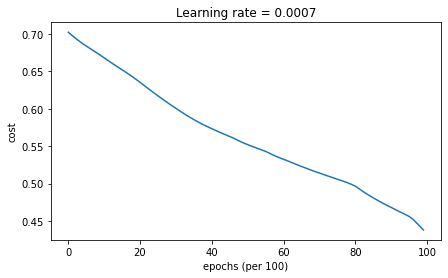

Accuracy: 0.7966666666666666


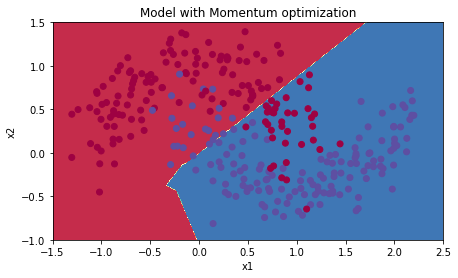

In [16]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, beta = 0.9, optimizer = "momentum")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Momentum optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

### Mini-batch gradient descent with momentum

Cost after epoch 0: 0.702413
Cost after epoch 1000: 0.668167
Cost after epoch 2000: 0.635388
Cost after epoch 3000: 0.600591
Cost after epoch 4000: 0.573444
Cost after epoch 5000: 0.552058
Cost after epoch 6000: 0.532458
Cost after epoch 7000: 0.514101
Cost after epoch 8000: 0.496652
Cost after epoch 9000: 0.468160


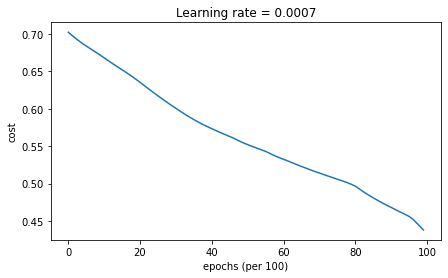

Accuracy: 0.7966666666666666


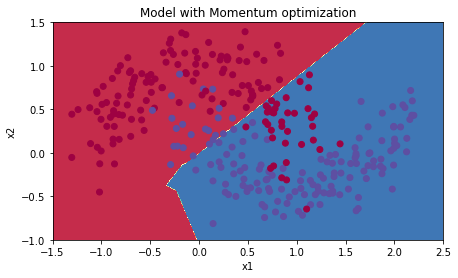

In [17]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, beta = 0.9, optimizer = "momentum")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Momentum optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

###  Mini-batch with Adam mode

Cost after epoch 0: 0.711598
Cost after epoch 1000: 0.156385
Cost after epoch 2000: 0.120745
Cost after epoch 3000: 0.112481
Cost after epoch 4000: 0.108458
Cost after epoch 5000: 0.106004
Cost after epoch 6000: 0.104435
Cost after epoch 7000: 0.103198
Cost after epoch 8000: 0.102372
Cost after epoch 9000: 0.101580


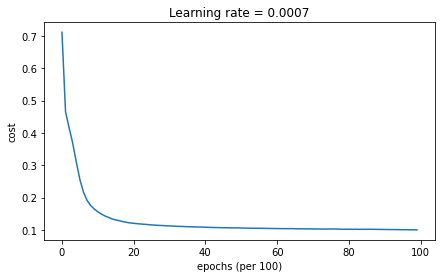

Accuracy: 0.9566666666666667


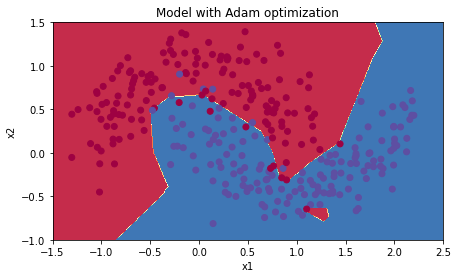

In [18]:
# train 3-layer model
layers_dims = [train_X.shape[0], 10,10, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "adam")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Adam optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

### Conclusions

Momentum usually helps, but given the small learning rate and the simplistic dataset, its impact is almost negligeable. Also, the huge oscillations you see in the cost come from the fact that some minibatches are more difficult thans others for the optimization algorithm.

Adam on the other hand, clearly outperforms mini-batch gradient descent and Momentum. If you run the model for more epochs on this simple dataset, all three methods will lead to very good results. However, you've seen that Adam converges a lot faster.

Some advantages of Adam include:

Relatively low memory requirements (though higher than gradient descent and gradient descent with momentum)
Usually works well even with little tuning of hyperparameters (except  αα )

**References**:

- Adam paper: https://arxiv.org/pdf/1412.6980.pdf